In [1]:
from utils_python import mcmcroutines as mcmc
from utils_python.transitmcmc import loglikehood, logprior, mcmcTransitModel
import utils_python.transitplot as transitp
import utils_python.transitfit as transitf
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import transitPy5 as tpy5
import numpy as np
from exotic_ld import StellarLimbDarkening

/home/aroy/venv/lib/python3.13/site-packages/exotic_ld/ld_grids.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Get the data file
tic = 149603524
datadir = "/data2/TESS/ffisearch/cvzsearch_yr1/cvz1toiv2/tlc" + str(tic) + "/"
datafile = "tlc" + str(tic) + ".p.dat"

# Read it
phot = tpy5.readphot(datadir + datafile)

phot.ferr = np.full(len(phot.flux), np.std(phot.flux))

# Read stellar info
st_info = np.genfromtxt(datadir + "stellar_mast.dat")

In [3]:
# Create an initial guess for all 18 parameters

epo = 0.70813
bper = 4.41202
depth = 0.0129872
tdur = 0.1367727

sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = kep.rhostar(bper, tdur)    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = np.median(phot.flux-1)       # Photometric zero point
sol.t0  = [epo]             # Center of transit time (days)
sol.per = [bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(depth)]  # Rp/R*
sol.ecw = [0.0]  # sqrt(e)cos(w)
sol.esw = [0.0]  # sqrt(e)sin(w)
sol.krv = [0.0]  # RV amplitude (m/s)
sol.ted = [0.0]  # thermal eclipse depth (ppm)
sol.ell = [0.0]  # Ellipsodial variations (ppm)
sol.alb = [0.0]  # Albedo amplitude (ppm)

# Find Kipping limb-darkening coefficients
M_H = st_info[7,1]
Teff = st_info[6,1]
logg = st_info[3,1]

ld_data_path = '/data2/rowe/exotic_ld_data/'
ld_model = 'mps1'
sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
sol.nl3 = ld[0]
sol.nl4 = ld[1]

In [4]:
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

llike_func, prior_func, sol_to_fit = mcmcTransitModel(sol, params_to_fit)
beta = [1.1823e-01, 1e-04, 3e-03, 8.5210e-05, 2.4424e-01, 3.2637e-03]
niter = 50000

time = phot.time - min(phot.time)

chain, accept = mcmc.genchain(sol_to_fit, beta, niter, transitm.transitModel, llike_func, prior_func,
                              mcmc.mhgmcmc, loglikeArgs=[time, phot.flux, phot.ferr, phot.itime], lpriorArgs=[time])

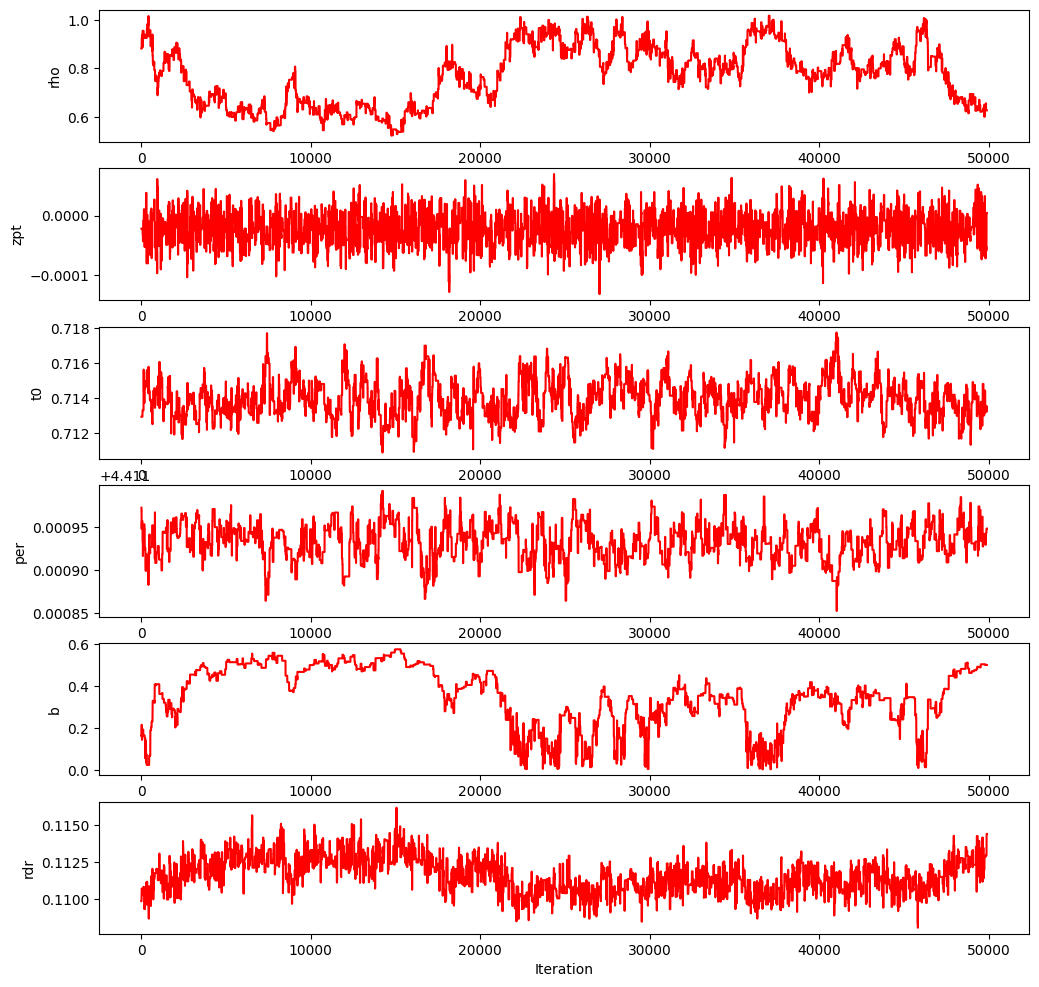

In [5]:
label = ["rho", "zpt", "t0", "per", "b", "rdr"]
color = ["red"]*6
burnin = 100

mcmc.plotchains(chain, label, color, burnin)

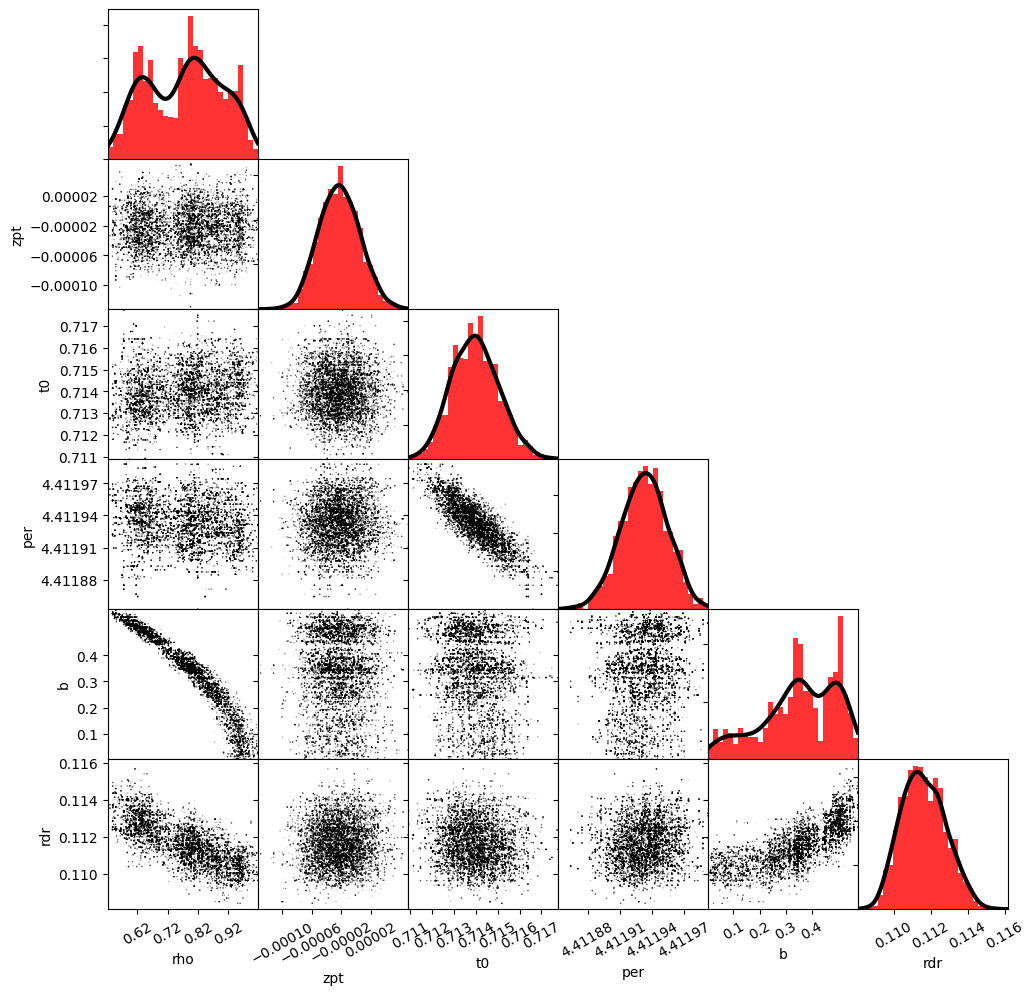

In [6]:
mcmc.triplot(chain, burnin, label, color, 30)

In [7]:
print('    mean  stdev')
npars=len(chain[1,:])
mm=np.zeros(npars)
for i in range(0,npars): #loop over all parameters
    mm[i]=np.mean(chain[burnin:,i])
    stdev=np.std(chain[burnin:,i])
    print('%s  %.5f %.5f' % (label[i], mm[i],stdev))

    mean  stdev
rho  0.77394 0.12153
zpt  -0.00002 0.00003
t0  0.71398 0.00107
per  4.41193 0.00002
b  0.35092 0.14257
rdr  0.11163 0.00116


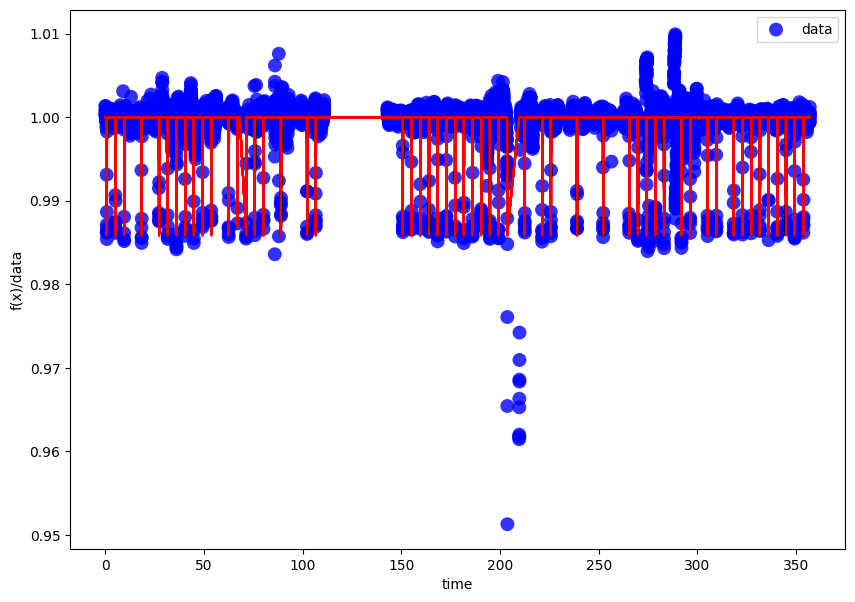

In [8]:
id_to_fit = [transitm.var_to_ind[param] for param in params_to_fit]
mcmc.plotmodels(time, phot.flux, chain, transitm.transitModel, burnin, sol.to_array(), id_to_fit, funcArgs=[phot.itime])

In [9]:
mcmc.calcacrate(accept, burnin, label)

Global Acceptance Rate: 0.209
rho Acceptance Rate 0.195
zpt Acceptance Rate 0.310
t0 Acceptance Rate 0.228
per Acceptance Rate 0.164
b Acceptance Rate 0.113
rdr Acceptance Rate 0.240


In [69]:
scale = mcmc.betarescale(sol_to_fit, beta, niter, burnin, transitm.transitModel, llike_func, prior_func,
                         mcmc.mhgmcmc, loglikeArgs=[time, phot.flux, phot.ferr, phot.itime], lpriorArgs=[time])

Too many iterations: icount > imax
Final Acceptance:  [0.25625    0.25308642 0.25316456 0.17730496 0.22289157 0.26515152]


In [11]:
chain1 = chain[:niter//3]
chain2 = chain[niter//3:2*niter//3]
chain3 = chain[2*niter//3:]
mcmc.gelmanrubin(chain1, chain2, chain3, burnin=burnin, npt=len(time))

array([1.55864164, 1.00031187, 1.01248167, 1.01197305, 1.41488056,
       1.29669186])